In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

2024-05-31 16:10:11.881733: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_parquet('dataset.parquet')

In [3]:
df['anomaly'] = df['anomaly'].astype(int)

In [4]:
df = df.drop(['time','sample','category','setting','action','active'], axis=1)

In [5]:
X = df.drop('anomaly', axis = 1)

In [6]:
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)
X_normalized = pd.DataFrame(X_normalized, columns=X.columns)

In [7]:
y = df['anomaly']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=.15, random_state=42)

In [9]:
X_train.shape[1]

130

In [14]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=[X_train.shape[1]]),
    layers.Dense(128, activation='relu'),
    layers.Dense(96, activation='relu'),
    layers.Dense(96, activation='relu'),
    layers.Dense(96, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'), 
    layers.Dense(1, activation='sigmoid'),
])

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 128)               16768     
                                                                 
 dense_9 (Dense)             (None, 128)               16512     
                                                                 
 dense_10 (Dense)            (None, 96)                12384     
                                                                 
 dense_11 (Dense)            (None, 96)                9312      
                                                                 
 dense_12 (Dense)            (None, 96)                9312      
                                                                 
 dense_13 (Dense)            (None, 64)                6208      
                                                                 
 dense_14 (Dense)            (None, 32)               

In [16]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

In [17]:
'''
early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)
'''
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=512,
    epochs=100,
    #callbacks=[early_stopping]
)

model.save('model.keras')

Epoch 1/100
3855/3855 [==============================] - 58s 14ms/step - loss: 0.5895 - binary_accuracy: 0.6936 - val_loss: 0.5811 - val_binary_accuracy: 0.6984
Epoch 2/100
3855/3855 [==============================] - 40s 10ms/step - loss: 0.5536 - binary_accuracy: 0.7207 - val_loss: 0.5383 - val_binary_accuracy: 0.7324
Epoch 3/100
3855/3855 [==============================] - 43s 11ms/step - loss: 0.5364 - binary_accuracy: 0.7333 - val_loss: 0.5413 - val_binary_accuracy: 0.7309
Epoch 4/100
3855/3855 [==============================] - 42s 11ms/step - loss: 0.5270 - binary_accuracy: 0.7399 - val_loss: 0.5205 - val_binary_accuracy: 0.7460
Epoch 5/100
3855/3855 [==============================] - 40s 11ms/step - loss: 0.5201 - binary_accuracy: 0.7447 - val_loss: 0.5223 - val_binary_accuracy: 0.7449
Epoch 6/100
3855/3855 [==============================] - 42s 11ms/step - loss: 0.5134 - binary_accuracy: 0.7488 - val_loss: 0.5117 - val_binary_accuracy: 0.7504
Epoch 7/100
3855/3855 [===========

Best Validation Loss: 0.3838
Best Validation Accuracy: 0.8235


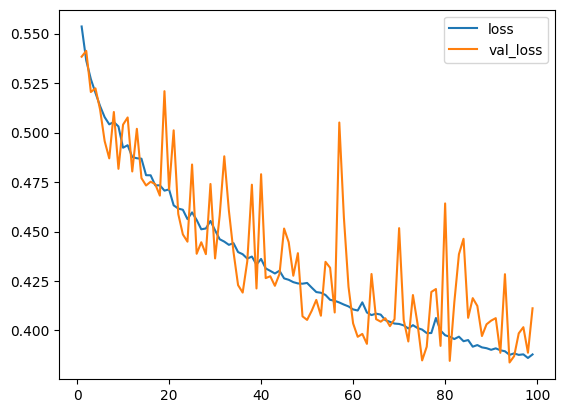

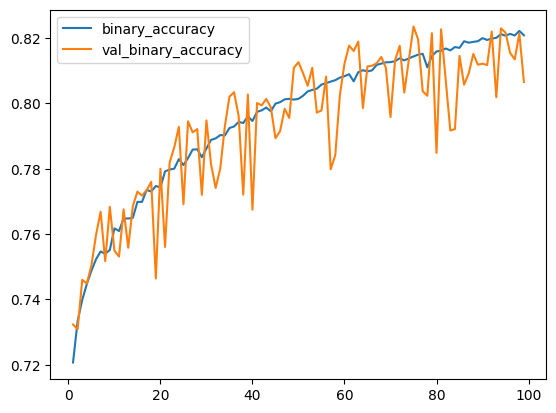

In [18]:
history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5
history_df.loc[1:, ['loss', 'val_loss']].plot()
history_df.loc[1:, ['binary_accuracy', 'val_binary_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_binary_accuracy'].max()))

In [19]:
y_pred_prob_test = model.predict(X_test)
y_pred_test = np.where(y_pred_prob_test.squeeze() < 0.5, 0, 1)
acc_test = metrics.accuracy_score(y_test, y_pred_test)
print(acc_test)

10883/10883 [==============================] - 20s 2ms/step
0.8065837004025798


In [20]:
accuracy = metrics.accuracy_score(y_test, y_pred_test)
precision = metrics.precision_score(y_test, y_pred_test)
recall = metrics.recall_score(y_test, y_pred_test)
f1 = metrics.f1_score(y_test, y_pred_test)
roc_auc = metrics.roc_auc_score(y_test, y_pred_prob_test)
conf_mat = metrics.confusion_matrix(y_test, y_pred_test)
pr_auc = metrics.average_precision_score(y_test, y_pred_prob_test)
metrics_TF = pd.Series({
'Accuracy': accuracy,
'Precision': precision,
'Recall': recall,
'F1-Score': f1,
'ROC AUC': roc_auc,
'PR AUC': pr_auc,
'Confusion Matrix': conf_mat,
})
print(metrics_TF)

Accuracy                                     0.806584
Precision                                    0.825719
Recall                                       0.583438
F1-Score                                      0.68375
ROC AUC                                      0.883933
PR AUC                                       0.826803
Confusion Matrix    [[208080, 15369], [51989, 72816]]
dtype: object


In [21]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob_test)
roc_auc = metrics.roc_auc_score(y_test, y_pred_prob_test)
# Calculate Precision-Recall curve and AUC
precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred_prob_test)
pr_auc = metrics.auc(recall, precision)

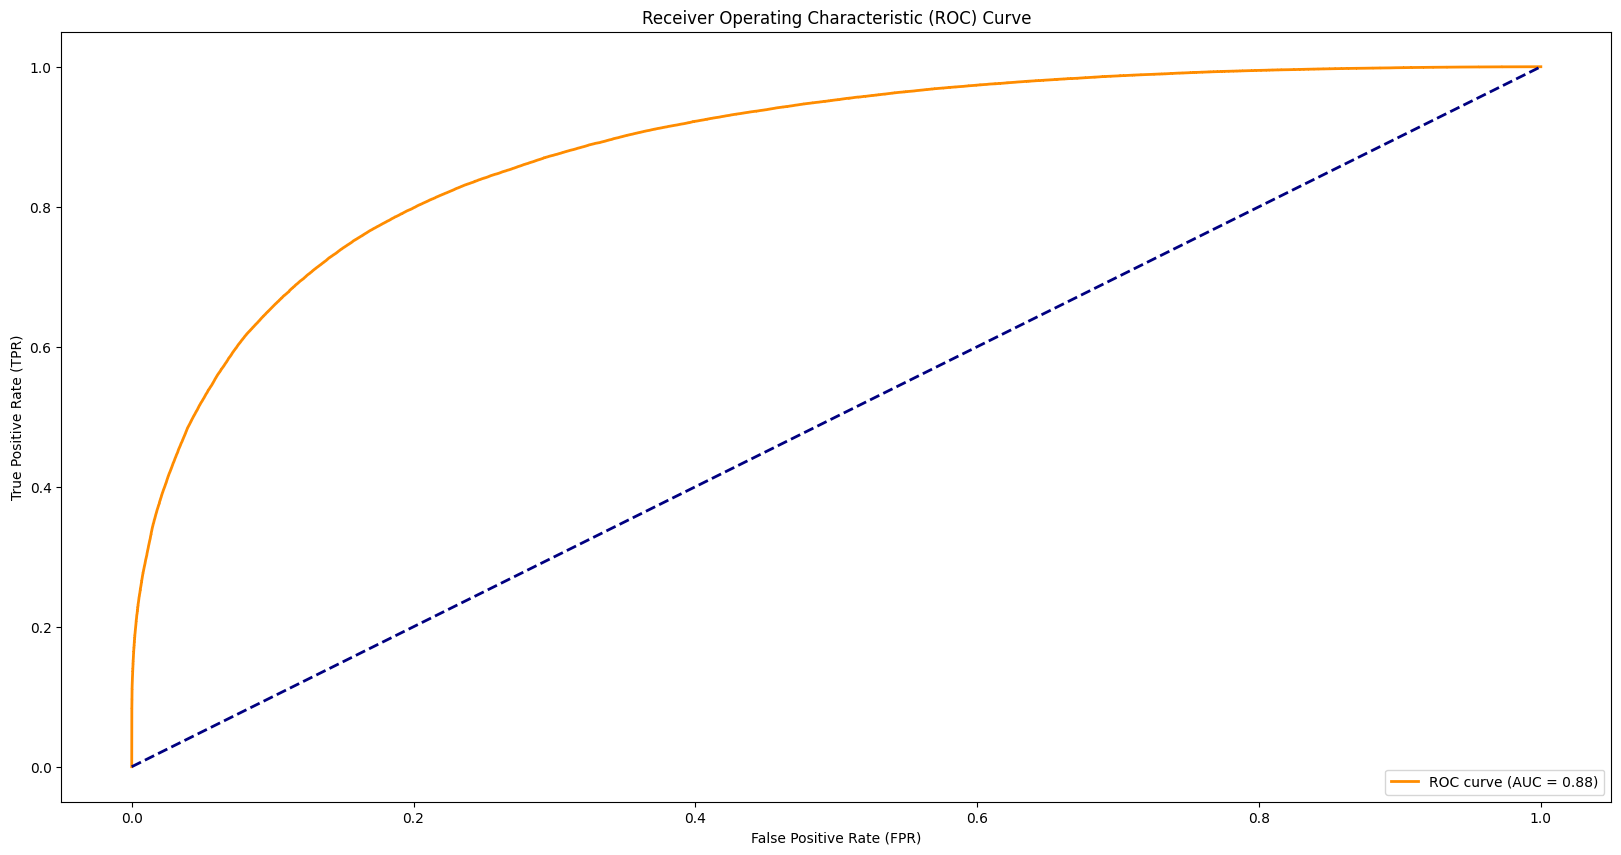

In [22]:
# Plot ROC curve
plt.figure(figsize=(20, 10))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

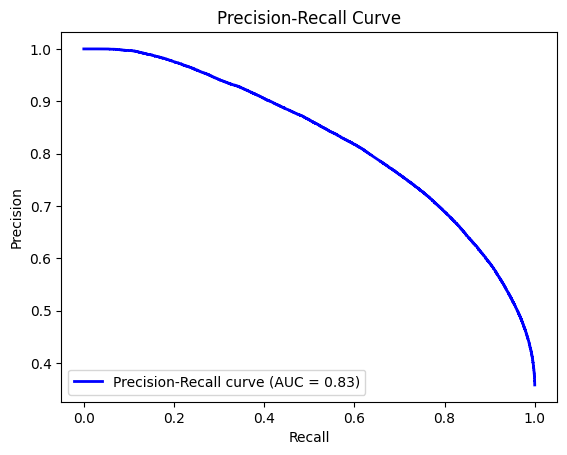

In [23]:
# Plot Precision-Recall curve
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

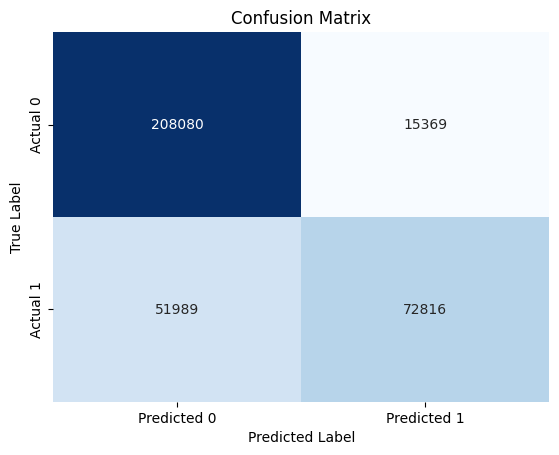

In [24]:
# Plot Confusion Matrix
conf_mat = metrics.confusion_matrix(y_test, y_pred_test)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()